# Adaptive 

In [1]:
import pandas as pd

from utils import *
from spin_ham import *
from bounds import *
from trotter import *

from functools import partial
from qiskit.quantum_info import random_statevector

figs_dir, data_dir = './figs', './data'

ModuleNotFoundError: No module named 'utils'

## Power-law

In [2]:
pow_test = Power_law(5, alpha=4, Jx=-1, Jy=-1, Jz=-1, hx=0.0, hy=0.0, hz=-0.5, pbc=False, verbose=False)
pow_test.ham
pow_test.ham_xyz
# commutator(pow_test.ham_xyz[0], pow_test.ham_xyz[1]).simplify()

[SparsePauliOp(['IIIXX', 'IIXIX', 'IXIIX', 'XIIIX', 'IIXXI', 'IXIXI', 'XIIXI', 'IXXII', 'XIXII', 'XXIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j]),
 SparsePauliOp(['IIIYY', 'IIYIY', 'IYIIY', 'YIIIY', 'IIYYI', 'IYIYI', 'YIIYI', 'IYYII', 'YIYII', 'YYIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j]),
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII', 'IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j,
  -0.5     +0.j, -0.5     +0.j, -0.5     +0.j, -0.5     +0.j, -0.5     +0.j])]

In [22]:
np.linalg.norm(SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n), ord=2)

6.0

### Error VS time

In [37]:
SparsePauliOp.from_list([('YY', np.pi / 8)])
SparsePauliOp.from_sparse_list([('ZZ', [1, 3], 1/(n))], n) 
SparsePauliOp.from_sparse_list([('ZZ', [i, j], 1) for j in range(0, n) for i in range(j+1, n)], n)
SparsePauliOp.from_list([('XXZYXYXZ',1 )])

SparsePauliOp(['XXZYXYXZ'],
              coeffs=[1.+0.j])

++++++++++++++++++++++++++++++++++++++++++++++++++

array([ 203.025282,  151.696606,   15.941487,   68.374832,   45.962447,
         48.313383,   42.638821,   22.291753,   86.603493,   34.067634,
        191.922857,   54.485394, 3195.434844,   30.25893 ,   91.911241,
         60.598971,   65.310616,   19.701211,  315.01863 ,  113.419667,
         33.789951,  118.662054,   96.472849,   77.201262,   90.303113,
         25.010513,   52.210872,   25.432291,   30.216636,   32.575948,
         16.259733,   53.632468,   27.110211,   30.376268,  633.713208,
        198.653316,   31.589203,   70.783232,  116.608845,   25.130693,
         88.988624,   36.15752 ,   78.694599,   51.747512,  423.127093,
        128.795203,   82.454857,   93.356293,   59.199584,   64.944432])

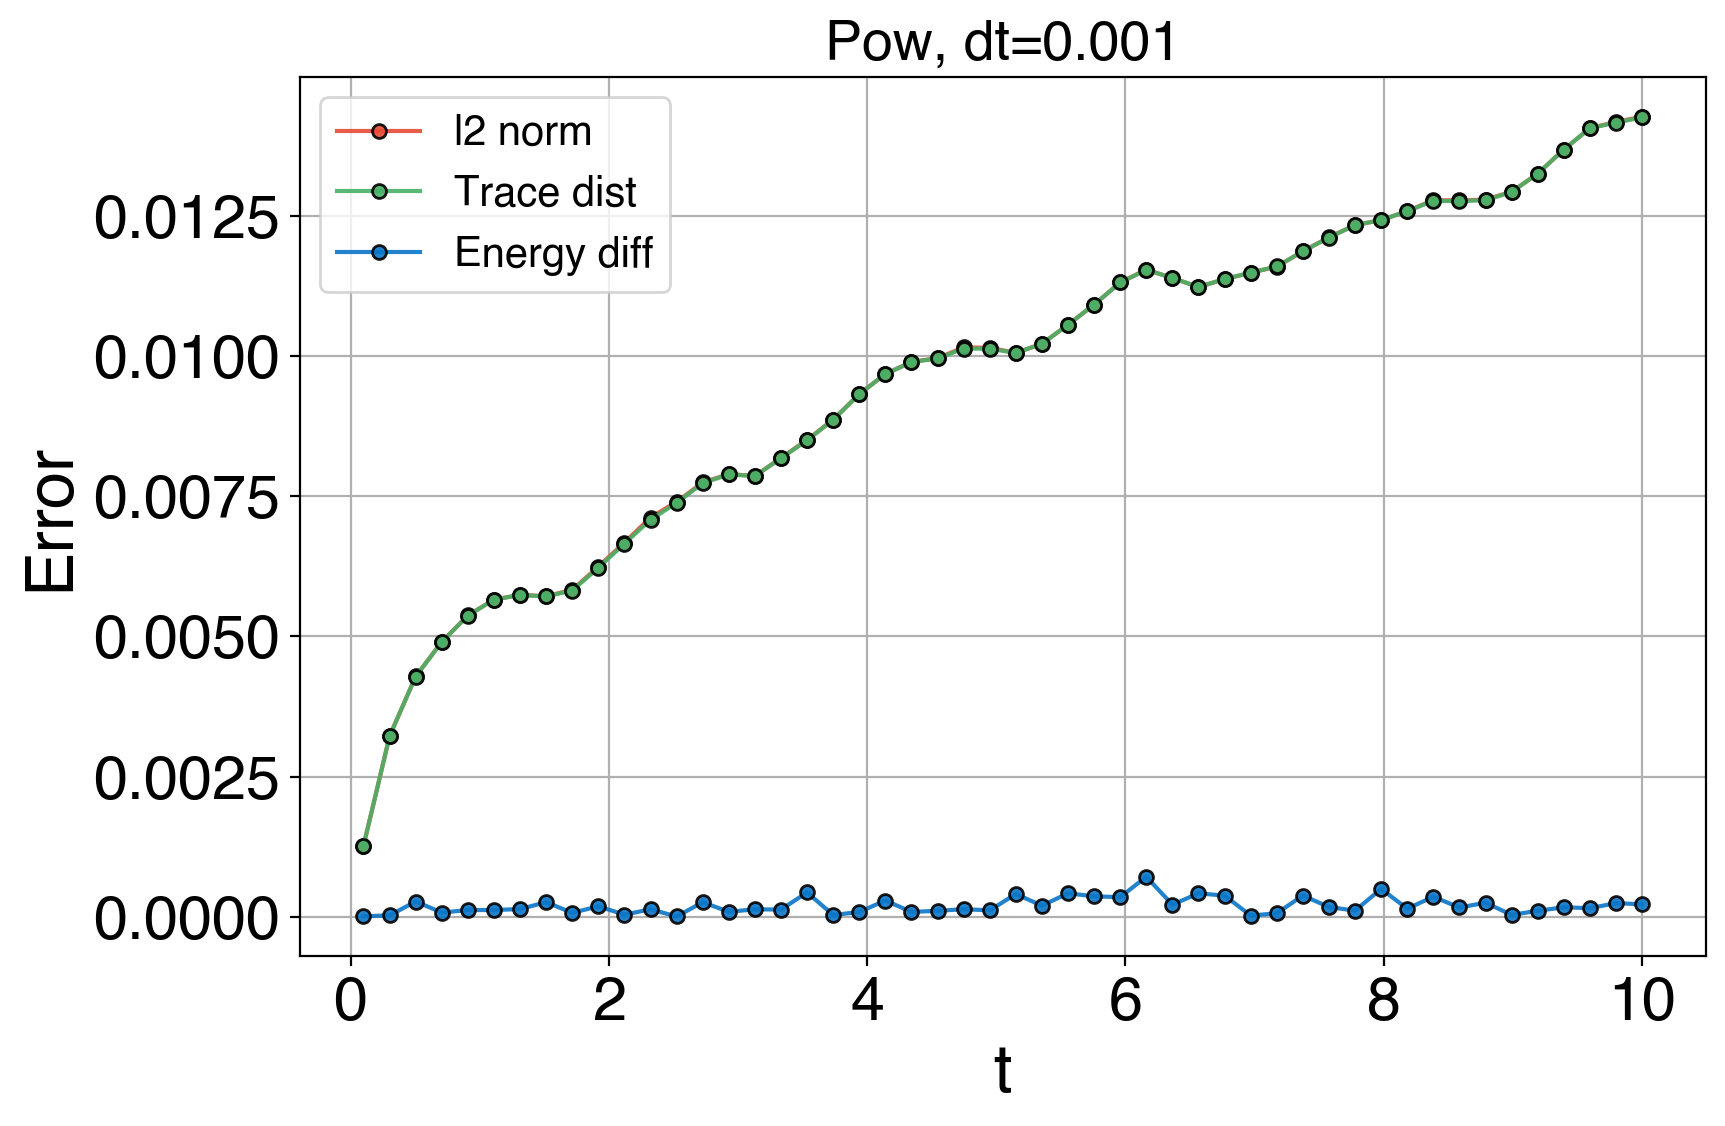

In [73]:
from openfermion.linalg import get_ground_state, get_sparse_operator
from qiskit.quantum_info import random_statevector, Statevector, SparsePauliOp
from fermion_ham import *
import random
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
from qiskit.quantum_info import random_statevector, Statevector, random_unitary

import jax, scipy

def trace_distance(rho, exact_U, appro_U):
    return np.linalg.norm(exact_U @ rho @ exact_U.conj().T - appro_U @ rho @ appro_U.conj().T, ord='nuc')

def expval_error(init_st, exact_U, appro_U, ob, use_dm=False, verbose=False):  
    if use_dm:
        init_dm = np.outer(init_st, init_st.conj())
        exact_dm, appro_dm = exact_U @ init_dm @ exact_U.conj().T, appro_U @ init_dm @ appro_U.conj().T
        error = np.trace(exact_dm @ ob) - np.trace(appro_dm @ ob)
    else:
        exact_st, appro_st = exact_U @ init_st, appro_U @ init_st
        error = exact_st.conj().T @ ob @ exact_st - appro_st.conj().T @ ob @ appro_st
    return abs(error)

# prefix, suffix = 'Chem', 't'
prefix, suffix = 'Pow', 't'

r = 100
n_sample = 50
t_max, t_n = 10, 50
t_list = np.linspace(0.1, t_max, t_n) 

# keys = ['worst_err', 'averg_err', 'averg_err_std', 'typic_err', 'worst_ob_err', 'averg_ob_err', 'averg_ob_err_std', 'typic_ob_err','t']
keys = ['trace_dist', 'l2_norm', 'energy_diff', 'op_diff', 'worst_err', 't']
data = dict([(k, []) for k in keys])
data['t'] = t_list

n = 8
J, h = 1, 0.5   

dt = 0.001
H = Nearest_Neighbour_1d(n=n, Jz=J, hx=1.7, hz=-0.5)
# H = TF_Ising_1d(n=n, J=-J, h=-h)
# H = Power_law(n, alpha=2, Jx=-1, Jy=-1, Jz=-1, hx=0.5, hy=0.2, hz=-0.2, pbc=False, verbose=False)
h_list = [h.to_matrix() for h in H.ham_xyz]
ob = H.ham.to_matrix()
# ob = ob @ ob @ ob

# n_hydrogen = 3
# n = n_hydrogen * 2
# d = 1.0

# H = hydrogen_chain_hamiltonian(n_hydrogen, d, verbose=False)
# h_list = H.hamiltonian_list
# ob = sum(h_list)

ob = SparsePauliOp.from_list([('Y'*n, 1)]).to_matrix()
# ob = SparsePauliOp.from_list([('XXZYXYXZ',1 )]).to_matrix()
# ob = SparsePauliOp.from_sparse_list([('ZZ', [i, j], 1) for j in range(0, n) for i in range(j+1, n)], n).to_matrix()
# ob = SparsePauliOp.from_sparse_list([('Z', [i], 1/(n)) for i in range(0, n)], n).to_matrix()
# ob = SparsePauliOp.from_sparse_list([('ZZ', [i, i+1], 1/(n-1)) for i in range(0, n-1)], n).to_matrix()
ob_norm = np.linalg.norm(ob, ord=2)
ob = ob/ob_norm
# ob = ob/ob_norm

# init_st = Statevector.from_label('+'*n).data
# init_st = Statevector.from_label('1'*n).data
# init_st = scipy.linalg.expm(-1j * SparsePauliOp.from_list([('Y'*n, np.pi / 8)]).to_matrix()) @ init_st
# init_st = scipy.linalg.expm(-1j * SparsePauliOp.from_sparse_list([('Y', [i], np.pi / 8) for i in range(0, n)], n).to_matrix()) @ init_st
# init_st = Statevector.from_label('11010101').data
init_st = random_statevector(2**n).data
init_dm = np.outer(init_st, init_st.conj())
# print(init_st)
# init_st = get_ground_state(tfi.ham.to_matrix())[1]
# init_st = np.linalg.eigh(exact_U - pf_AB(par_group, 3, r, ord=2))[1][-1]
# init_st = np.linalg.eigh(exact_U - appro_U)[1][-1]
# rand_states = [random_statevector(2**n) for _ in range(n_sample)]

# exact_U_dt = scipy.linalg.expm(-1j * dt * sum(h_list))
exact_U_dt = scipy.linalg.expm(-1j * dt * sum(h_list))
appro_U_dt = pf_r(h_list, dt, 1, order=2, use_jax=False)

for t in t_list:
    # print(f'------ t = {t} ------')
    print(f'+', end='')
    r = int(t/dt)
    # magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], num_qubits=n).to_matrix()
    # magn_op = SparsePauliOp('XYIIIIII').to_matrix()
    # ob = magn_op

    # print(rand_states)

    exact_U = scipy.linalg.expm(-1j * t * sum(h_list))
    # exact_U = scipy.linalg.expm(-1j * t * H.ham)
    # par_group = [h.to_matrix(True) for h in H.ham_parity]
    appro_U = pf_r(h_list, t, r, order=1, use_jax=False)
    # assert np.allclose(exact_U, scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in H.ham_xyz])))

    exact_st, appro_st = exact_U @ init_st, appro_U @ init_st
    data['worst_err'].append(2*r*np.linalg.norm(exact_U_dt - appro_U_dt, ord=2))
    data['trace_dist'].append(trace_distance(init_dm, exact_U, appro_U))
    data['l2_norm'].append(2*np.linalg.norm(exact_st - appro_st, ord=2))
    data['op_diff'].append(2*np.linalg.norm((exact_U_dt - appro_U_dt) @ appro_st, ord=2))
    # data['energy_diff'].append(np.abs(exact_st.conj().T @ ob @ exact_st - appro_st.conj().T @ ob @ appro_st))
    data['energy_diff'].append(expval_error(init_st, exact_U, appro_U, ob, use_dm=True))
    # print("energy: ", init_st.conj().T @ exact_U.conj().T @ ob @ exact_U @ init_st, init_st.conj().T @ appro_U.conj().T @ ob @ appro_U @ init_st)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')

# ax.plot(data['t'], data['worst_err'], '.-', label='Worst-case')
# ax.plot(data['t'], [item*(t_list[index]/dt) for index, item in enumerate(data['op_diff'])], '.-', label='op diff')
# ax.plot(data['t'], [(t_max/t_n/dt)*sum(data['op_diff'][:i+1]) for i in range(len(data['op_diff']))], '.-', label='Integral op diff')
ax.plot(data['t'], data['l2_norm'], '.-', label='l2 norm')
ax.plot(data['t'], data['trace_dist'], '.-', label='Trace dist')
ax.plot(data['t'], data['energy_diff'], '.-', label='Energy diff')

ax.set_title(rf'{prefix}, dt={dt}')
ax.set_xlabel(rf't')
ax.set_ylabel(rf'Error')
ax.grid()
# ax.loglog()
ax.legend()
fig.savefig(f'{figs_dir}/{prefix}_n={n}_adaptive.pdf', dpi=150, bbox_inches='tight')
np.divide(data['trace_dist'], data['energy_diff'])

In [68]:
np.divide(data['trace_dist'], data['energy_diff'])

array([ 62.712214, 104.031592,  59.214471,  17.698881,  73.136054,
        26.883994,  76.836777,  31.950707,  56.30875 ,   8.894562,
        32.090239, 359.065004,  15.542673,  28.186319,  26.118313,
        32.11935 , 713.508663,  51.383755,  44.202148,  36.392678,
        37.915718,  18.738164,  23.442815,  18.216088,  49.002455,
       109.000008,  21.323297,  58.512225,  28.551012,  46.53042 ,
        20.206619,  35.58386 ,  14.137549,  94.766945,  43.645968,
        22.607872,  33.116395, 895.747859,  33.799012, 110.880126,
       714.777711,  13.353476,  32.299317,  99.491085,  18.333827,
        20.014451,  70.565877,  35.338975,  22.229174,  33.064289])

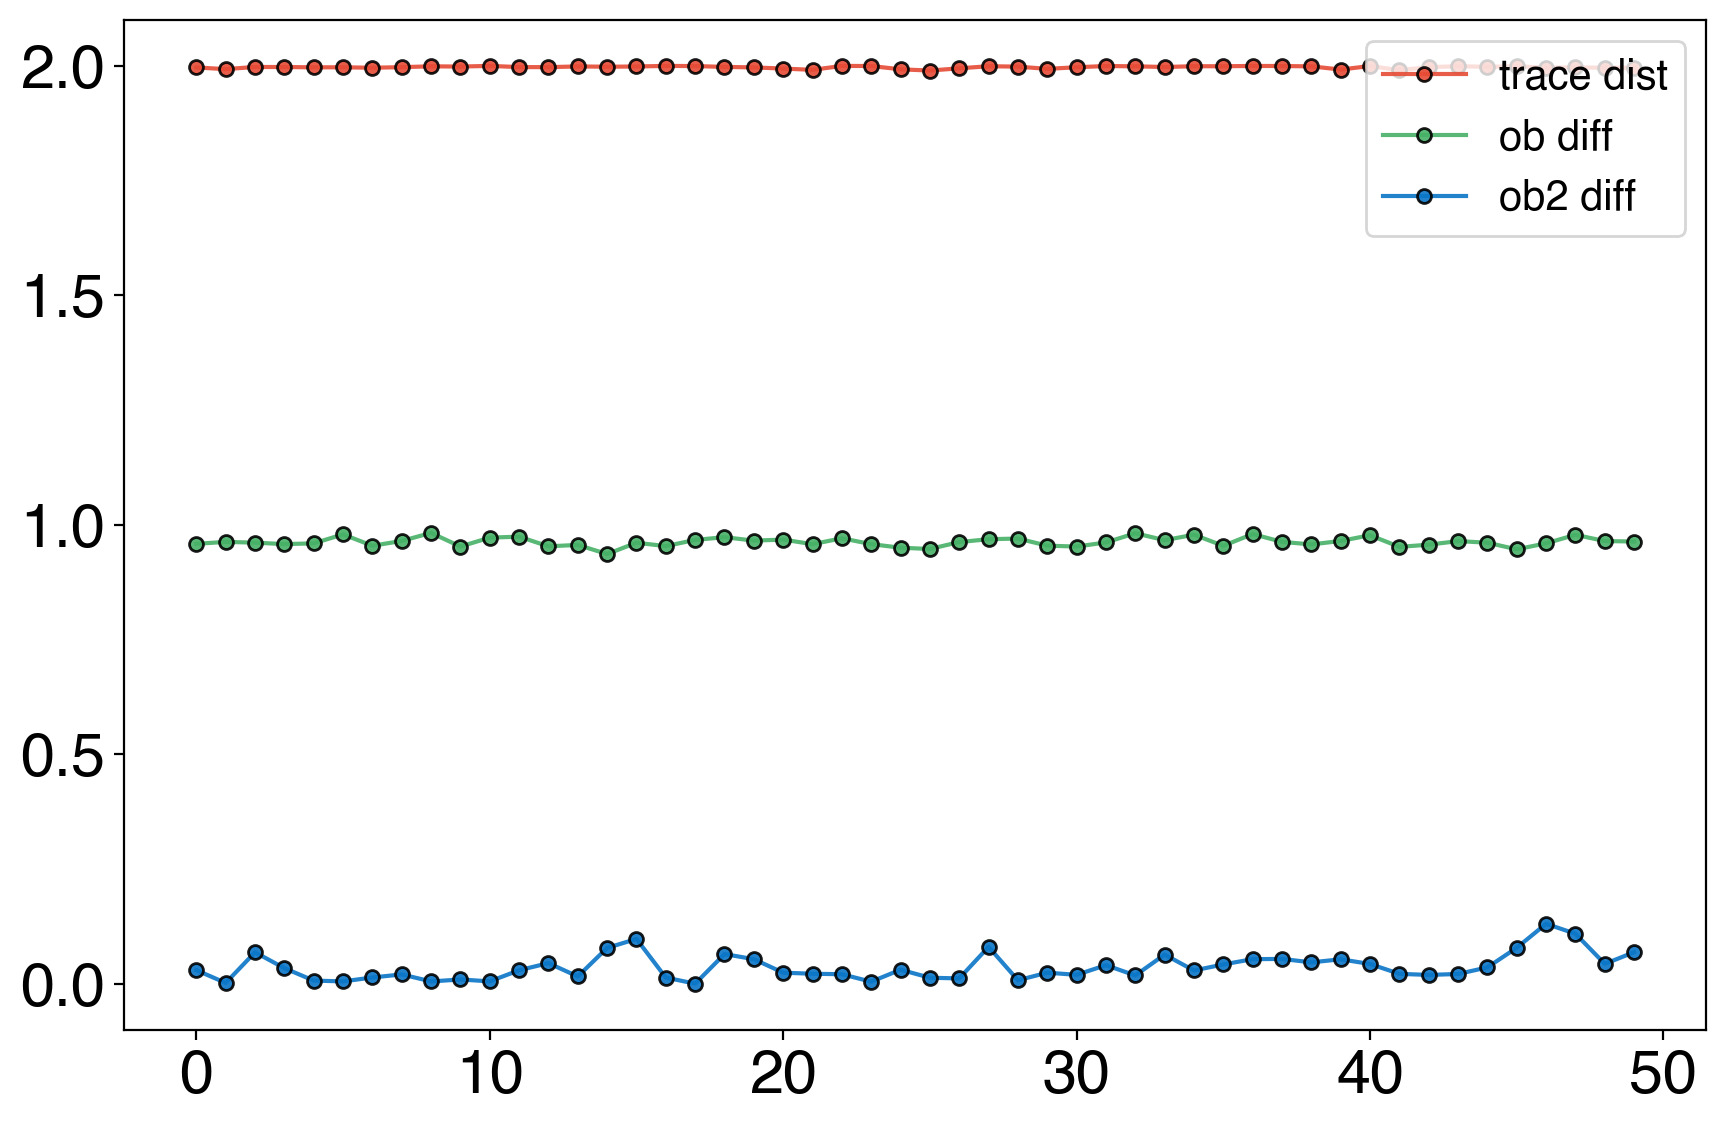

In [66]:
n_sample = 50
ob = SparsePauliOp.from_list([('X'*n, 1)]).to_matrix() + SparsePauliOp.from_sparse_list([('ZZ', [i, j], 1) for j in range(0, n) for i in range(j+1, n)], n).to_matrix() + SparsePauliOp.from_list([('XXZYXYXZ',1 )]).to_matrix()
ob2 =  SparsePauliOp.from_list([('XXZYXYXZ',1 )]).to_matrix()
# ob = SparsePauliOp.from_list([('Z'*n, 1)]).to_matrix()
ob_norm = np.linalg.norm(ob, ord=2)
ob = ob/ob_norm

rand_st1 = [Statevector.from_label('0'*n).data for _ in range(n_sample)]
# rand_st1 = [random_statevector(2**n).data for _ in range(n_sample)]
rand_st2 = [random_statevector(2**n).data for _ in range(n_sample)]
tr_d_list = [np.linalg.norm(np.outer(rand_st1[i], rand_st1[i].conj())-np.outer(rand_st2[i], rand_st2[i].conj()), ord='nuc') for i in range(n_sample)]
expval_list = [np.abs(rand_st1[i].conj().T @ ob @ rand_st1[i] - rand_st2[i].conj().T @ ob @ rand_st2[i])  for i in range(n_sample)]
expval_list2 = [np.abs(rand_st1[i].conj().T @ ob2 @ rand_st1[i] - rand_st2[i].conj().T @ ob2 @ rand_st2[i])  for i in range(n_sample)]

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
ax.plot(range(n_sample), tr_d_list, '.-', label='trace dist')
ax.plot(range(n_sample), expval_list, '.-', label='ob diff')
ax.plot(range(n_sample), expval_list2, '.-', label='ob2 diff')
ax.legend()

In [7]:
integral_list = [(t_max/t_n/dt)*sum(data['op_diff'][:i+1]) for i in range(len(data['op_diff']))]
np.divide(integral_list, data['trace_dist'])

array([2.006181, 1.61421 , 1.811065, 2.044359, 2.204442, 2.375787,
       2.502118, 2.632725, 2.71756 , 2.838834, 3.001758, 3.09562 ,
       3.200021, 3.285983, 3.381488, 3.485138, 3.607745, 3.76158 ,
       3.921184, 4.010668, 4.203078, 4.360362, 4.553653, 4.689277,
       4.84407 , 4.927297, 4.979339, 4.929652, 4.911449, 4.893088,
       4.870818, 4.826126, 4.817725, 4.827603, 4.889789, 4.962069,
       4.976887, 4.96319 , 4.965815, 5.00841 , 5.061246, 5.058797,
       5.053144, 5.074519, 5.071218, 5.042524, 5.063188, 5.146036,
       5.233202, 5.275948])

In [15]:
np.outer(exact_st.conj().T, exact_st) - np.outer(appro_st.conj().T, appro_st)
np.linalg.norm(np.outer(exact_st.conj().T, exact_st) - np.outer(appro_st.conj().T, appro_st), ord='nuc')

NameError: name 'exact_st' is not defined

## Nearest-neighbor interaction

## Chemistry

In [ ]:
from fermion_ham import *
import random
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
from qiskit.quantum_info import random_statevector, Statevector, random_unitary

import jax, scipy

prefix, suffix = 'Chem', 't'
# dir = '../figs'

rand_type = 'haar' # '1'
d = 1.0
n_hydrogen = 3
n = n_hydrogen * 2
H = hydrogen_chain_hamiltonian(n_hydrogen, d, verbose=False)
ground_state_energy, ground_state =  get_ground_state(get_sparse_operator(H.fermion_hamiltonian))
# ground_state = Statevector.from_label('0'*n).data
# ground_state = random_statevector(2**(2*n_hydrogen)).data
init_st = ground_state
# print('init state: ', init_st)  
r = 100
n_sample = 500
t_list = np.linspace(0.1, 15, 15)
# dt = 0.1
dt = 1/10

h_ob = sum([h for h in h2_init.hamiltonian_list])
exact_U = scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))



In [116]:
from qiskit.quantum_info import random_statevector, Statevector, random_unitary
init_st = Statevector.from_label('0000').data
## tensor product of four random unitaries
def tensor_random_unitaries(n):
    rand_U_list = [random_unitary(2).data for _ in range(n)]
    global_random_U = rand_U_list[0]
    for i in range(1, n):
        global_random_U = np.kron(global_random_U, rand_U_list[i]) 
    return global_random_U
# tensor_random_unitaries(4) @ init_st

In [4]:
from fermion_ham import *
import random
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
from qiskit.quantum_info import random_statevector, Statevector, random_unitary

test_H = hydrogen_chain_hamiltonian(2, 1, verbose=False)


# pstr: 15, ['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'YXXY', 'YYXX', 'XXYY', 'XYYX', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ']
# groups: 2
[[{'IIII': (-0.3276081896748102+0j)}, {'ZIII': (0.13716572937099497+0j)}, {'IZII': (0.13716572937099497+0j)}, {'IIZI': (-0.13036292057109025+0j)}, {'IIIZ': (-0.13036292057109025+0j)}, {'ZZII': (0.15660062488237947+0j)}], [{'YXXY': (0.049197645871367546+0j)}, {'YYXX': (-0.049197645871367546+0j)}, {'XXYY': (-0.049197645871367546+0j)}, {'XYYX': (0.049197645871367546+0j)}, {'ZIZI': (0.10622904490856078+0j)}, {'ZIIZ': (0.15542669077992832+0j)}, {'IZZI': (0.15542669077992832+0j)}, {'IZIZ': (0.10622904490856078+0j)}, {'IIZZ': (0.16326768673564335+0j)}]]


In [16]:
test_H.qubit_terms

[<16x16 sparse matrix of type '<class 'numpy.complex128'>'
 	with 16 stored elements in Compressed Sparse Column format>,
 <16x16 sparse matrix of type '<class 'numpy.complex128'>'
 	with 16 stored elements in Compressed Sparse Column format>,
 <16x16 sparse matrix of type '<class 'numpy.complex128'>'
 	with 16 stored elements in Compressed Sparse Column format>,
 <16x16 sparse matrix of type '<class 'numpy.complex128'>'
 	with 16 stored elements in Compressed Sparse Column format>,
 <16x16 sparse matrix of type '<class 'numpy.complex128'>'
 	with 16 stored elements in Compressed Sparse Column format>,
 <16x16 sparse matrix of type '<class 'numpy.complex128'>'
 	with 16 stored elements in Compressed Sparse Column format>,
 <16x16 sparse matrix of type '<class 'numpy.complex128'>'
 	with 16 stored elements in Compressed Sparse Column format>,
 <16x16 sparse matrix of type '<class 'numpy.complex128'>'
 	with 16 stored elements in Compressed Sparse Column format>,
 <16x16 sparse matrix of

In [159]:
n = 6
k= 3
[(random.choices(['I','X','Y','Z'], k=k), random.sample(list(range(0, n)), k), 1)]
# "".join(random.choices(['I','X','Y','Z'], k=n))

[(['X', 'Y', 'Y'], [0, 3, 5], 1)]

In [4]:
from fermion_ham import *
import random
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
from qiskit.quantum_info import random_statevector, Statevector, random_unitary

import jax, scipy

prefix, suffix = 'Chem', 't'
# dir = '../figs'

rand_type = 'haar' # '1'
d = 1.0
n_hydrogen = 3
n = n_hydrogen * 2
h2_init = hydrogen_chain_hamiltonian(n_hydrogen, d, verbose=False)
h2_finl = hydrogen_chain_hamiltonian(n_hydrogen, 2*d, verbose=False)
# print(get_ground_state(get_sparse_operator(h2_init.fermion_hamiltonian)))
# print(get_ground_state(get_sparse_operator(h2_finl.fermion_hamiltonian)))

# print(h2_init.jw)
ground_state_energy, ground_state =  get_ground_state(get_sparse_operator(h2_init.fermion_hamiltonian))
# print('ground energy: ', ground_state_energy, ground_state)
# vec0 = np.array([0 for _ in range(len(ground_state))])
# vec0[-1] = 1
# ground_state = vec0/np.sqrt(2)  + ground_state / np.sqrt(2) 
# ground_state = Statevector.from_label('+'*n).data/np.sqrt(2)  + Statevector.from_label('1100').data / np.sqrt(2) 
# ground_state = Statevector.from_label('+'*n).data
ground_state = Statevector.from_label('0'*n).data
# ground_state = random_statevector(2**(2*n_hydrogen)).data
init_st = ground_state.T
# print('init state: ', init_st)  
r = 100
n_sample = 500
t_list = np.linspace(0.1, 15, 15)
# dt = 0.1
dt = 1/10

chem_keys = ['worst_err', 'averg_err', 'averg_err_std', 'typic_err', 'typic_err_trace', 'worst_ob_err', 'averg_ob_err', 'averg_ob_err_std', 'typic_ob_err','t']
chem_data = dict([(k, []) for k in chem_keys])
chem_data['t'] = t_list

# h_ob =  SparsePauliOp.from_sparse_list([('XX', [i, i+1], 1/(n-1)) for i in range(0, n-1)], num_qubits=n).to_matrix()
# h_ob =  SparsePauliOp.from_sparse_list([('Y', [i], 1/n) for i in range(0, n)], num_qubits=n).to_matrix()
rand_ob_str = "".join(random.choices(['I','X','Y','Z'], k=n))
# rand_ob_str = 'IIXI'
print("rand_ob_str: ", rand_ob_str)
h_ob = SparsePauliOp(rand_ob_str).to_matrix()
rand_pstr_list = ["".join(random.choices(['I','X','Y','Z'], k=n)) for _ in range(4)]
print('rand_pstr_list: ', rand_pstr_list)
# h_ob = (SparsePauliOp(rand_pstr_list[0]) + SparsePauliOp(rand_pstr_list[1])).to_matrix()
h_ob = sum([h for h in h2_init.hamiltonian_list])
# h_ob = sum([SparsePauliOp.from_sparse_list([(random.choices(['I','X','Y','Z'], k=n), random.sample(list(range(0, n)), n), 1)], n) for _ in range(5)]).to_matrix()
# h_ob = h_ob / np.linalg.norm(h_ob, ord=2)
h_ob_1norm = np.linalg.norm(h2_init.pstrs_coeff, ord=1)
for t in t_list:
    # print(f'------t: {t}-----')  
    print(f'+', end='')
    r = int(t/dt)
    # print("H norm: ", np.linalg.norm(sum([h for h in h2_init.hamiltonian_list]), ord=2) )
    exact_U = scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
    # h_list = h2_finl.qubit_terms
    h_list = h2_finl.hamiltonian_list
    appro_U = pf_r(h_list, t, r, order=2, use_jax=False)
    # exact_U = jax.scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
    # h_list = h2_finl.hamiltonian_list
    # appro_U = pf_r(h_list, t, r, order=2, use_jax=True)
    if rand_type == 'haar':
        rand_states = [random_statevector(len(exact_U)) for _ in range(n_sample)]
    elif rand_type == '1':
        rand_states = [Statevector(tensor_random_unitaries(n) @ Statevector.from_label('0'*n).data) for _ in range(n_sample)]
    else:
        raise ValueError('rand_type should be either haar or 1')
    M = exact_U - appro_U
    U, S, V = np.linalg.svd(M)
    # init_st = V[0].T

    chem_data['worst_err'].append(2*np.linalg.norm(exact_U - appro_U, ord=2))
    averg_st_err = [np.linalg.norm(h_ob, ord=2) * np.linalg.norm(np.outer(exact_U @ state.data.conj().T , (exact_U @ state.data.conj().T).conj().T) - np.outer(appro_U @ state.data.conj().T, (appro_U @ state.data.conj().T).conj().T), ord='nuc') for state in rand_states] 
    # averg_st_err = [np.linalg.norm(exact_U @ state.data.conj().T - appro_U @ state.data.conj().T) for state in rand_states]
    # print(averg_ob_err)
    chem_data['averg_err'].append(np.mean(averg_st_err))
    chem_data['averg_err_std'].append(np.std(averg_st_err))
    exact_st = exact_U @ init_st
    appro_st = appro_U @ init_st
    # chem_data['typic_err'].append(np.linalg.norm(np.outer(exact_st, exact_st.conj().T) - np.outer(appro_st, appro_st.conj().T), ord='nuc'))
    chem_data['typic_err_trace'].append(2*np.linalg.norm(np.outer(exact_st, exact_st.conj().T) - np.outer(appro_st, appro_st.conj().T), ord='nuc'))
    chem_data['typic_err'].append(2*np.linalg.norm(exact_U @ init_st - appro_U @ init_st))
    # print(ground_state.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ ground_state)

    chem_data['worst_ob_err'].append(np.linalg.norm(exact_U.conj().T @ h_ob @ exact_U - appro_U.conj().T @ h_ob @ appro_U, ord=2))
    averg_ob_err = [np.abs(state.data.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ state.data - state.data.conj().T @ appro_U.conj().T @ h_ob @ appro_U @ state.data) for state in rand_states]
    chem_data['averg_ob_err'].append(np.mean(averg_ob_err))
    chem_data['averg_ob_err_std'].append(np.std(averg_ob_err))
    chem_data['typic_ob_err'].append( np.abs(init_st.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ init_st - init_st.conj().T @ appro_U.conj().T @ h_ob @ appro_U @ init_st))
    # print("energy: ", init_st.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ init_st, init_st.conj().T @ appro_U.conj().T @ h_ob @ appro_U @ init_st)


# pstr: 62, ['IIIIII', 'ZIIIII', 'YZZZYI', 'XZZZXI', 'IZIIII', 'IYZZZY', 'IXZZZX', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'ZZIIII', 'YIZZYI', 'XIZZXI', 'YXXYII', 'YYXXII', 'XXYYII', 'XYYXII', 'ZYZZZY', 'ZXZZZX', 'YXIIXY', 'YYIIXX', 'XXIIYY', 'XYIIYX', 'ZIZIII', 'YZIZYI', 'XZIZXI', 'ZIIZII', 'YZZIYI', 'XZZIXI', 'YZYYZY', 'YZYXZX', 'XZXYZY', 'XZXXZX', 'ZIIIZI', 'ZIIIIZ', 'YZZZYZ', 'XZZZXZ', 'IZZIII', 'IYIZZY', 'IXIZZX', 'IYXXYI', 'IYYXXI', 'IXXYYI', 'IXYYXI', 'IZIZII', 'IYZIZY', 'IXZIZX', 'IZIIZI', 'IYZZIY', 'IXZZIX', 'IZIIIZ', 'IIZZII', 'IIYXXY', 'IIYYXX', 'IIXXYY', 'IIXYYX', 'IIZIZI', 'IIZIIZ', 'IIIZZI', 'IIIZIZ', 'IIIIZZ']
# groups: 22
[[{'IIIIII': (-0.33362884012829697+0j)}, {'ZIIIII': (0.16891173410254534+0j)}, {'YZZZYI': (0.0004614778443555352+0j)}], [{'XZZZXI': (0.0004614778443555352+0j)}, {'IZIIII': (0.16891173410254526+0j)}, {'IYZZZY': (0.00046147784435555516+0j)}], [{'IXZZZX': (0.00046147784435555516+0j)}, {'IIZIII': (0.020862150051427164+0j)}, {'IIIZII': (0.02086215005142716+

In [5]:
worst_st_err_bnd = 2 * h_ob_1norm * tight_bound(h_list, 2, 1, 10, type='spectral')
averg_st_err_bnd = 2 * h_ob_1norm * tight_bound(h_list, 2, 1, 10, type='fro')

onestep_exactU = scipy.linalg.expm(-1j * dt * sum([herm for herm in h_list]))
d = len(h_list[0])
E_op = onestep_exactU - pf_r(h_list, dt, 1, order=2, use_jax=False)
# print((np.trace(E_op @ E_op.conj().T @ E_op @ E_op.conj().T)/d)**(1/4))
# averg_ob_err_bnd = 2 * (np.trace(E_op @ E_op.conj().T @ E_op @ E_op.conj().T)/d)**(1/4) * (np.trace(h_ob @ h_ob @ h_ob @ h_ob)/d)**(1/4)
print("EEEE:", 2 * (np.trace(E_op @ E_op.conj().T @ E_op @ E_op.conj().T)/d)**(1/4) * (np.trace(h_ob @ h_ob @ h_ob @ h_ob)/d)**(1/4), "Fro:", 2 * (np.trace(E_op @ E_op.conj().T)/d)**(1/2) ) 
averg_ob_err_bnd = 2 * tight_bound(h_list, 2, 1, 10, type='4') * (np.trace(h_ob @ h_ob @ h_ob @ h_ob)/d)**(1/4)
# print( 2 * (np.trace(E_op @ E_op.conj().T)/d)**(1/2))
# print( 2 * (np.trace(E_op @ E_op.conj().T @ E_op @ E_op.conj().T)/d)**(1/4) )
# print((np.trace(h_ob @ h_ob @ h_ob @ h_ob)/d)**(1/4))
print(worst_st_err_bnd, averg_st_err_bnd, averg_ob_err_bnd)
print( 2 * tight_bound(h_list, 2, 1, 10, type='4'), (np.trace(h_ob @ h_ob @ h_ob @ h_ob)/d)**(1/4))

EEEE: (5.661386972774727e-06-3.0905612449423607e-24j) Fro: (4.451729649547679e-06+6.362777701118939e-25j)
0.009819972240223542 0.0035874049962433758 (0.0012333679927831924+0j)
(0.0013428272046044044+0j) (0.918486003675016+0j)


In [10]:
# plt.errorbar(chem_data['t'][::s], chem_data['averg_err'][::s], chem_data['averg_err_std'][::s], fmt='o-', label='Average w/o observable (Empirical)', capsize=5, color='#0A75C7FF')
# plt.errorbar(chem_data['t'][::s], chem_data['averg_ob_err'][::s], chem_data['averg_ob_err_std'][::s], fmt='o--', capsize=5, color='#F39B7FFF')